In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import importlib

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

In [2]:
# constants
csts = dict()
csts['k'] = 1.380649e-23  # J/K
csts['A'] = 3.15*0.92*1e-6  # m
csts['L'] = 10.00e-3  # m
csts['I'] = 10.0e-3  # A
#add error

## Interpolate Data

#### Functions

In [3]:
def v_to_mag(v_to_convert):
    """
    Get field strength from a voltage reading
    """
    calib_raw = pd.read_excel('magnet_calibration.xlsx')
    voltage = calib_raw['Hall Probe Reading'].values[2:]
    field = calib_raw['Magnetic Flux Reading'].values[2:]

    func = interp1d(voltage, field, bounds_error=False, fill_value="extrapolate")
    field_interp = func(v_to_convert)
    return field_interp

In [4]:
def interp_data(dataset, T_common):
    """
    Interpolate first over time (to match data within the file) 
    and then over temperature (to match data between files)
    """
    interp_dataset = dict()

    # Interpolating over time
    common_time = dataset["t9"]  # using time of temperature readings
    # Go through channels
    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")  # interpolate data for channel i
        interp_dataset[f'v{i}'] = interp_data(common_time)  # interpolate data for channel i at common time

    # Interpolating over temperature
    for i in range(1, 8):
        interp_data = interp1d(dataset['T'], interp_dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")  # interpolate data for channel i
        interp_dataset[f'v{i}'] = interp_data(T_common)  # updating data for channel i at common Temperature
    
    # Save temperature arrays
    interp_dataset['T_original'] = dataset['T']
    interp_dataset['T_common'] = T_common
    
    return interp_dataset

#### Interpolate

In [5]:
# defining the common temperature array we want to interpolate over
T_common = np.linspace(-100, 80, 1000) # Celcius

In [6]:
# read the files listed in the .txt and interpolate them
mag_field_dict = dict()
file_list = user_path + '/PHYS469/hall_experiment/good_data_list.txt'  # files need to be in order of increasing field strength
raw_data = dict()

with open(file_list, 'r') as f:
    for line in f:
        # Read in data file
        line = line.strip()
        dataset = pd.read_csv(user_path + line, header=2)

        # Get field strength from file name
        field_voltage = float(line.split('/')[-1].split('.')[0][:-2])
        field_strength = v_to_mag(field_voltage)
        
        # Keep raw data in a dict
        raw_data[str(field_strength)] = dataset

        # Interpolate the data
        run_dict = interp_data(dataset, T_common)
        # Save data in dict with field strength as key
        mag_field_dict[str(field_strength)] = run_dict

print(f'{mag_field_dict.keys()}\n{mag_field_dict['275.7'].keys()}')

dict_keys(['0.6000000000000014', '191.9', '275.7', '325.2', '406.8', '489.2', '559.3'])
dict_keys(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'T_original', 'T_common'])


In [7]:
# Combining the voltage data at diff fields into single arrays, in a single dict
voltage_dict = dict()

# Adding temperature array
voltage_dict['T_common'] = T_common
# Adding field strength array
voltage_dict['B_array'] = np.array([float(field) for field in mag_field_dict.keys()])
# Adding voltage matrices
for i in range(1, 8):
    voltage_dict[f'v{i}'] = np.array([mag_field_dict[field][f'v{i}'] 
                                      for field in mag_field_dict.keys()]).T  # shape (N_B, N_T)
    
print(voltage_dict.keys())

dict_keys(['T_common', 'B_array', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7'])


## Functions

In [8]:
def get_temp(T, dict=voltage_dict):
    """
    Return index and value of closest temperature to T in the temperature array of dict
    """
    # Find data at the temperature
    T_index = np.argmin(np.abs(dict['T_common'] - T))
    T = dict['T_common'][T_index]

    return T, T_index

In [9]:
def get_field(B, dict=voltage_dict):
    """
    Return index and value of closest field to B in the field array of dict
    """
    B_index = np.argmin(np.abs(dict['B_array'] - B))
    B = dict['B_array'][B_index]

    return B, B_index

## 3d Interpolated Data Plots

Yes, the two functions below do the exact same thing :)

In [10]:
# def voltage_3d_plot_from_field_dict(channel, mag_field_dict=mag_field_dict):
#     """
#     Make the 2d plot from a magnetic field dict
#     keys are fields, with values being other dictionaries that store the voltages
#     """
    
#     # Channel info
#     channel_num = channel[1]

#     # Data
#     V = np.array([mag_field_dict[B][channel] for B in mag_field_dict.keys()])  # shape (n_B, n_T)
#     V = V.T  # shape (n_T, n_B)
#     B = [float(field) for field in mag_field_dict.keys()]  # Field values in mT

#     # Plot
#     plt.figure(figsize=(6,4), dpi=150)
#     extent = (mag_field_dict['T_common'][0], mag_field_dict['T_common'][-1], B[-1], B[0])
#     plt.imshow(np.abs(V), aspect='auto', cmap='viridis', extent=extent)
#     plt.title(f"Channel {channel_num} Voltage")
#     plt.colorbar(label='Voltage [V]')
#     plt.xlabel("Temperature [C]")
#     plt.ylabel("Magnetic Field [mT]")
#     plt.show()

In [11]:
def voltage_3d_plot_from_volt_dict(channel, data_dict=voltage_dict):
    """
    Make the 2d plot from a voltage data dictionary
    voltage arrays are in the form of a matrix with shape (n_T, n_B), ie, already concatenated along the B axis
    """
    # Channel info
    channel_num = channel[1]

    # Data
    V = data_dict[channel]  # shape (n_T, n_B)
    B = data_dict['B_array'] # Field values in mT
    T = data_dict['T_common']  # Temperature values in C

    # Plot
    plt.figure(figsize=(6,4), dpi=150)
    extent = (T[0], T[-1], B[-1], B[0])
    plt.imshow(np.abs(V), aspect='auto', cmap='viridis', extent=extent)
    plt.title(f"Channel {channel_num} Voltage")
    plt.colorbar(label='Voltage [V]')
    plt.xlabel("Temperature [C]")
    plt.ylabel("Magnetic Field [mT]")
    plt.show()

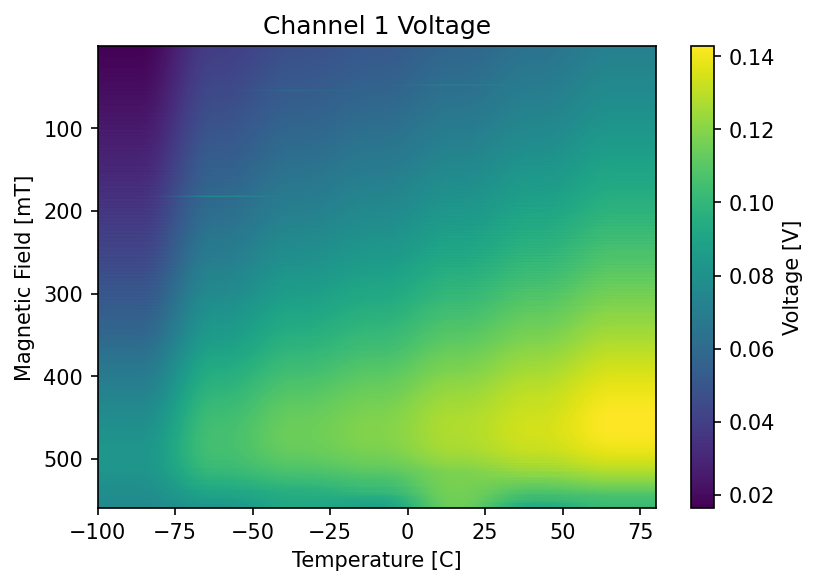

In [39]:
for channel in ['v1']:#, 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']:
    voltage_3d_plot_from_volt_dict(channel)

In [ ]:
def plot_slice(T, dict=voltage_dict):
    

## Resistivity

In [13]:
def resistivity(V, csts):
    return V *csts['A'] / (csts['I'] * csts['L'])

In [35]:
def plot_resistivity(B, dict=voltage_dict, csts=csts):
    # Get ambient field
    B_ambient, B_ambient_index = get_field(B)
    # Get temperature
    T = dict['T_common']
    
    # Get voltage data at ambient field for V5 & V7
    V5 = dict['v5'][:,B_ambient_index]
    V7 = dict['v7'][:,B_ambient_index]
    # Calcylate Vx
    Vx = (V5+V7)/2
    
    # Calculate resistivity
    rho = resistivity(Vx, csts)

    # Plot
    plt.figure(figsize=(6,4), dpi=150)
    plt.scatter(T, rho, marker='o',s=6)
    # plt.plot(T, rho)
    plt.title(f"Resistivity at {B_ambient:.1f} mT, Interpolated Data")
    plt.xlabel("Temperature [C]")
    plt.ylabel(r"Resistivity [$\Omega$m]")
    plt.show()


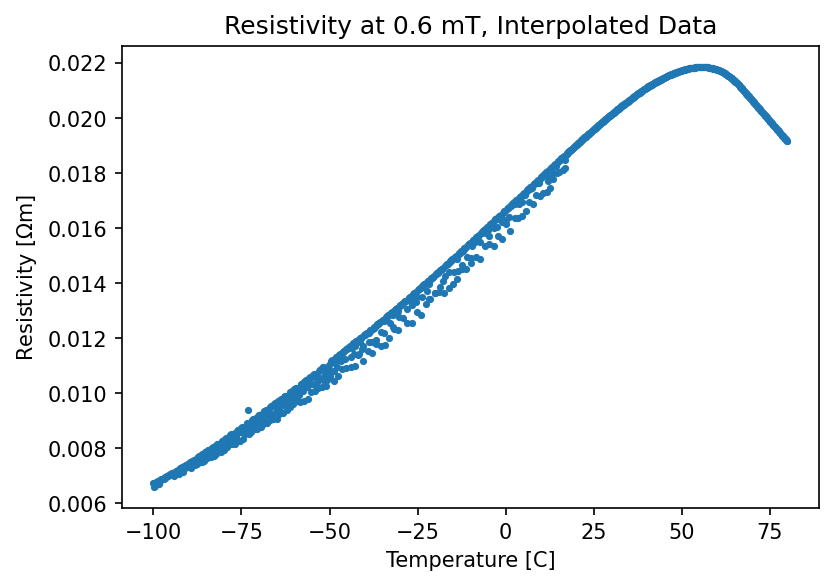

In [36]:
B_ambient = 0  # mT
plot_resistivity(B_ambient)

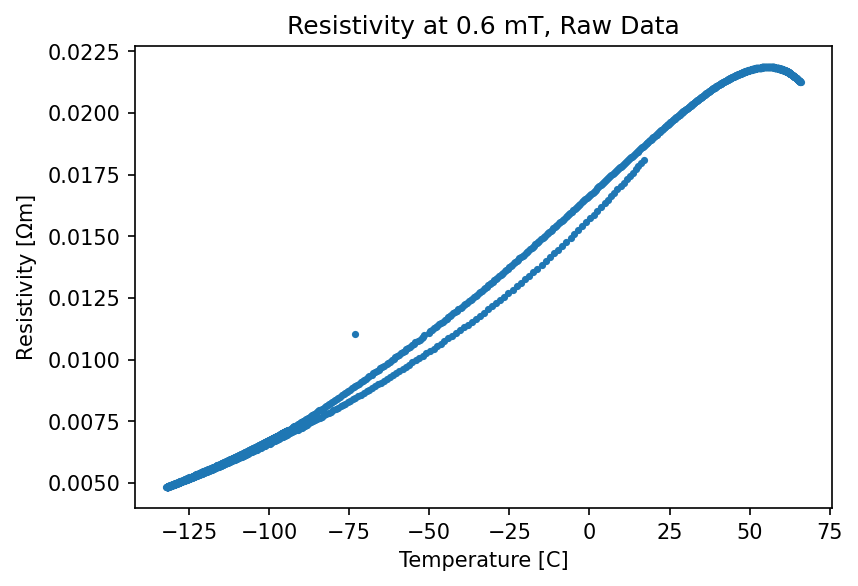

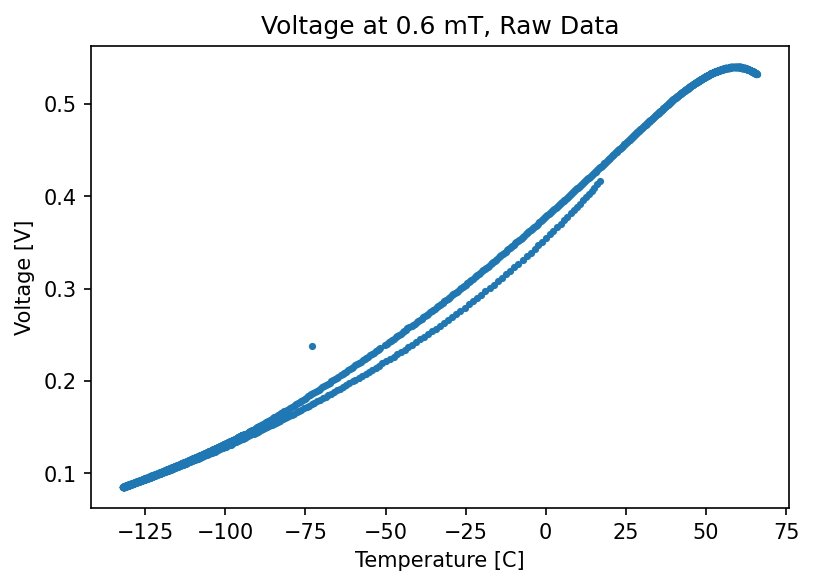

In [37]:
# Using this code cell to check if the weird line is due to 
# interpolation or if it's in the raw data...

B = float(list(raw_data.keys())[0])
T = raw_data[f'{B}']['T']

# Get voltage data at ambient field for V5 & V7
V5 = raw_data[f'{B}']['v5']
V7 = raw_data[f'{B}']['v7']
# Calcylate Vx
Vx = (V5+V7)/2

# Calculate resistivity
rho = resistivity(Vx, csts)

# Plot
plt.figure(figsize=(6,4), dpi=150)
plt.scatter(T, rho, marker='o',s=6)
plt.title(f"Resistivity at {B:.1f} mT, Raw Data")
plt.xlabel("Temperature [C]")
plt.ylabel(r"Resistivity [$\Omega$m]")
plt.show()

plt.figure(figsize=(6,4), dpi=150)
plt.scatter(T, V5, marker='o',s=6)
plt.title(f"Voltage at {B:.1f} mT, Raw Data")
plt.xlabel("Temperature [C]")
plt.ylabel("Voltage [V]")
plt.show()


## Carrier Concentration